<a href="https://colab.research.google.com/github/erika0915/fake-news-detection/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D,  Subtract, Lambda, Conv1D, GlobalMaxPooling1D, Multiply, Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, Attention
from tensorflow.python.keras.callbacks import Callback
from keras.utils import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import ast
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/기학_팀플젝/박채연/embedding/0.5sampled_embedding/embedding완/embedded_0.5_newsdata_train.csv')
test = pd.read_csv('/content/drive/MyDrive/기학_팀플젝/박채연/embedding/0.5sampled_embedding/embedding완/embedded_0.5_newsdata_test.csv')

In [ ]:
train = train.drop(columns = ['processLevel', 'processPattern'])
test = test.drop(columns = ['processLevel', 'processPattern'])

In [ ]:
# 결측값을 빈 리스트로 대체
train['newsTitle'] = train['newsTitle'].fillna('[]')
train['newsContent'] = train['newsContent'].fillna('[]')
test['newsTitle'] = test['newsTitle'].fillna('[]')
test['newsContent'] = test['newsContent'].fillna('[]')

In [ ]:
# 1. 데이터 패딩
X_train_title_raw = [ast.literal_eval(x) for x in train['newsTitle']]
X_train_content_raw = [ast.literal_eval(x) for x in train['newsContent']]
X_test_title_raw = [ast.literal_eval(x) for x in test['newsTitle']]
X_test_content_raw = [ast.literal_eval(x) for x in test['newsContent']]

# 고정된 길이로 패딩
# X_train끼리 길이 맞추기
X_train_title = pad_sequences(X_train_title_raw, padding='post', dtype='float32',
                              maxlen=max(len(x) for x in X_train_title_raw))
X_train_content = pad_sequences(X_train_content_raw, padding='post', dtype='float32',
                                maxlen=max(len(x) for x in X_train_content_raw))

# X_test끼리 길이 맞추기
X_test_title = pad_sequences(X_test_title_raw, padding='post', dtype='float32',
                             maxlen=max(len(x) for x in X_test_title_raw))
X_test_content = pad_sequences(X_test_content_raw, padding='post', dtype='float32',
                               maxlen=max(len(x) for x in X_test_content_raw))

In [ ]:
y_train = np.array(train['useType'], dtype=np.float32)
y_test = np.array(test['useType'], dtype=np.float32)

In [ ]:
#train set
# Text-CNN 용 데이터
X_combined = np.concatenate((X_train_title, X_train_content), axis=1)  # 제목과 내용을 병합
X_combined = X_combined.reshape(X_combined.shape[0], X_combined.shape[1], 1)  # (샘플 수, 벡터 길이, 채널 수)

# Siamese CNN 용 데이터
X_train_title = X_train_title.reshape(X_train_title.shape[0], X_train_title.shape[1], 1)  # (샘플 수, 벡터 길이, 채널 수)
X_train_content = X_train_content.reshape(X_train_content.shape[0],X_train_content.shape[1], 1)  # (샘플 수, 벡터 길이, 채널 수)

In [ ]:
#test set
# Text-CNN 용 데이터
X_combined_test = np.concatenate((X_test_title, X_test_content), axis=1)  # 제목과 내용을 병합
X_combined_test = X_combined_test.reshape(X_combined_test.shape[0], X_combined_test.shape[1], 1)  # (샘플 수, 벡터 길이, 채널 수)

# Siamese CNN 용 데이터
X_test_title = X_test_title.reshape(X_test_title.shape[0], X_test_title.shape[1], 1)  # (샘플 수, 벡터 길이, 채널 수)
X_test_content = X_test_content.reshape(X_test_content.shape[0],X_test_content.shape[1], 1)  # (샘플 수, 벡터 길이, 채널 수)

CNN을 사용하되 아키텍쳐는 Text-CNN과 Siamese CNN을 사용해볼 것임

Text-CNN은 주로 문장 분류, 감정 분석에 활용되는 기법으로, text에 특화된 CNN 아키텍쳐라고 볼 수 있고, Siamese의 경우는 두 데이터의 embedding 차이를 보는 아키텍쳐이기 때문에 유사도를 판별하는 데 유의미할 것이라고 생각하여 사용했다.

In [ ]:
def cnntext_model(input_dim):
    input_layer = Input(shape=(input_dim, 1))  # 입력: (시퀀스 길이, 1)

    # 여러 필터 크기를 사용하는 CNN 병렬 구성
    conv_blocks = []
    filter_sizes = [3, 4, 5, 6]  # 다양한 n-gram 학습
    for size in filter_sizes:
        conv = Conv1D(256, size, activation='relu')(input_layer)
        pool = GlobalMaxPooling1D()(conv)
        conv_blocks.append(pool)

    # 병렬 CNN 블록 합치기
    merged = Concatenate()(conv_blocks)

    # Fully Connected Layer
    dense = Dense(256, activation='relu')(merged)
    dropout = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(dropout)  # 이진 분류

    model = Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
def siamese_cnn(input_dim):
    # 공유되는 CNN
    def shared_cnn(input_layer):
        conv = Conv1D(256, 5, activation='relu')(input_layer)
        pool = GlobalMaxPooling1D()(conv)
        return pool

    # 제목과 내용을 각각 입력
    title_input = Input(shape=(input_dim, 1))
    content_input = Input(shape=(input_dim, 1))

    # 공유 CNN을 각각 적용
    title_features = shared_cnn(title_input)
    content_features = shared_cnn(content_input)

    # 특징 벡터 차이 계산 (유사도 분석)
    diff = Subtract()([title_features, content_features])
    output = Dense(1, activation='sigmoid')(diff)  # 이진 분류

    model = Model(inputs=[title_input, content_input], outputs=output)
    return model

In [ ]:
#아키텍쳐 개선
def multi_siamese_cnn(input_dim):

    # 공유 CNN 구조
    def shared_cnn(input_layer):
        conv = Conv1D(256, kernel_size=5, activation='relu')(input_layer)
        pool = GlobalMaxPooling1D()(conv)
        return pool

    # 제목과 내용을 각각 입력
    title_input = Input(shape=(input_dim, 1))
    content_input = Input(shape=(input_dim, 1))

    # 공유 CNN 적용
    title_features = shared_cnn(title_input)
    content_features = shared_cnn(content_input)


    # 특징 결합 방식 확장
    diff = Subtract()([title_features, content_features])  # 절대 차이
    mul = Multiply()([title_features, content_features])   # 곱
    combined = Concatenate()([title_features, content_features, diff, mul])  # 결합

    # Fully Connected Layer
    dense = Dense(512, activation='relu')(combined)
    dropout = Dropout(0.5)(dense)
    dense2 = Dense(128, activation='relu')(dropout)
    dropout2 = Dropout(0.5)(dense2)

    # 최종 출력
    output = Dense(1, activation='sigmoid')(dropout2)

    # 모델 정의
    model = Model(inputs=[title_input, content_input], outputs=output)
    return model

In [ ]:
#아키텍쳐 개선 2 _ 어텐션 사용
def attention_siamese_cnn(input_dim):
    # 공유 CNN 구조
    def shared_cnn(input_layer):
        conv = Conv1D(256, kernel_size=5, activation='relu')(input_layer)
        pool = GlobalMaxPooling1D()(conv)
        return pool

    # 입력 정의
    title_input = Input(shape=(input_dim, 1))
    content_input = Input(shape=(input_dim, 1))

    # Self-Attention
    attention = Attention()([title_input, content_input])
    attention_features = GlobalMaxPooling1D()(attention)

    # 공유 CNN 적용
    title_features = shared_cnn(title_input)
    content_features = shared_cnn(content_input)

    # 특징 결합
    combined = Concatenate()([title_features, content_features, attention_features])

    # Fully Connected Layer
    dense = Dense(512, activation='relu')(combined)
    dropout = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(dropout)

    # 모델 정의
    model = Model(inputs=[title_input, content_input], outputs=output)
    return model

In [ ]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [ ]:
#batch_size와 epoch 수는 통일
batch_size = 64
epochs = 20

In [ ]:
results=[]

Text-CNN 컴파일

In [ ]:
from tensorflow.python.keras.engine import data_adapter

def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset

In [ ]:
# Text-CNN 모델 학습
text_cnn_model = cnntext_model(input_dim=300)  # Text-CNN 모델 생성
text_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
text_cnn_model.fit(X_combined, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Epoch 1/20
1502/1502 [==============================] - 25s 13ms/step - loss: 0.6923 - accuracy: 0.5200 - val_loss: 0.6907 - val_accuracy: 0.5264
Epoch 2/20
1502/1502 [==============================] - 20s 13ms/step - loss: 0.6901 - accuracy: 0.5323 - val_loss: 0.6879 - val_accuracy: 0.5415
Epoch 3/20
1502/1502 [==============================] - 19s 12ms/step - loss: 0.6883 - accuracy: 0.5420 - val_loss: 0.6861 - val_accuracy: 0.5480
Epoch 4/20
1502/1502 [==============================] - 19s 13ms/step - loss: 0.6863 - accuracy: 0.5471 - val_loss: 0.6836 - val_accuracy: 0.5578
Epoch 5/20
1502/1502 [==============================] - 19s 13ms/step - loss: 0.6848 - accuracy: 0.5542 - val_loss: 0.6829 - val_accuracy: 0.5588
Epoch 6/20
1502/1502 [==============================] - 19s 13ms/step - loss: 0.6832 - accuracy: 0.5558 - val_loss: 0.6811 - val_accuracy: 0.5622
Epoch 7/20
1502/1502 [==============================] - 19s 13ms/step - loss: 0.6821 - accuracy: 0.5595 - val_loss: 0.6783 -

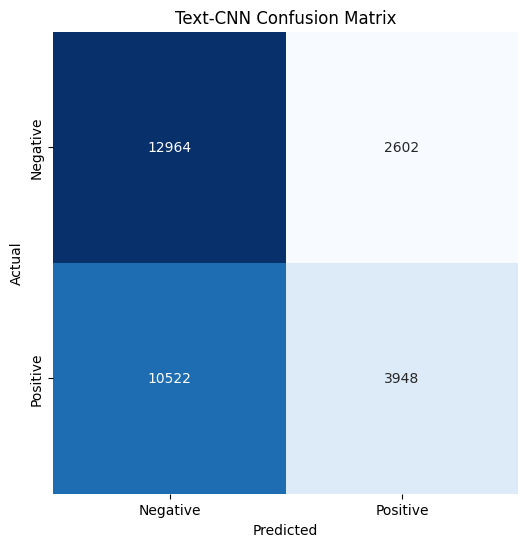

In [ ]:
# Text-CNN 모델 예측
y_pred_text_cnn = (text_cnn_model.predict(X_combined_test) > 0.5).astype(int)

# Text-CNN 평가
accuracy_text_cnn = accuracy_score(y_test, y_pred_text_cnn)
precision_text_cnn = precision_score(y_test, y_pred_text_cnn)
recall_text_cnn = recall_score(y_test, y_pred_text_cnn)
conf_matrix_text_cnn = confusion_matrix(y_test, y_pred_text_cnn)


results.append({
                    "Model": "Text-CNN",
                    "Accuracy": accuracy_text_cnn,
                    "Precision": precision_text_cnn,
                    "Recall": recall_text_cnn,
                    "Confusion Matrix" : conf_matrix_text_cnn
                })

# Text-CNN Confusion Matrix 시각화
plot_confusion_matrix(conf_matrix_text_cnn, "Text-CNN")

In [ ]:
# Siamese-CNN 모델 학습
siamese_model = siamese_cnn(input_dim=150)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.fit([X_train_title, X_train_content], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/20
1502/1502 [==============================] - 8s 5ms/step - loss: 0.6893 - accuracy: 0.5331 - val_loss: 0.6852 - val_accuracy: 0.5501
Epoch 2/20
1502/1502 [==============================] - 9s 6ms/step - loss: 0.6853 - accuracy: 0.5527 - val_loss: 0.6813 - val_accuracy: 0.5659
Epoch 3/20
1502/1502 [==============================] - 8s 5ms/step - loss: 0.6834 - accuracy: 0.5550 - val_loss: 0.6801 - val_accuracy: 0.5655
Epoch 4/20
1502/1502 [==============================] - 7s 5ms/step - loss: 0.6821 - accuracy: 0.5590 - val_loss: 0.6792 - val_accuracy: 0.5661
Epoch 5/20
1502/1502 [==============================] - 8s 5ms/step - loss: 0.6815 - accuracy: 0.5599 - val_loss: 0.6784 - val_accuracy: 0.5648
Epoch 6/20
1502/1502 [==============================] - 7s 5ms/step - loss: 0.6806 - accuracy: 0.5628 - val_loss: 0.6775 - val_accuracy: 0.5699
Epoch 7/20
1502/1502 [==============================] - 8s 6ms/step - loss: 0.6793 - accuracy: 0.5634 - val_loss: 0.6780 - val_accuracy:

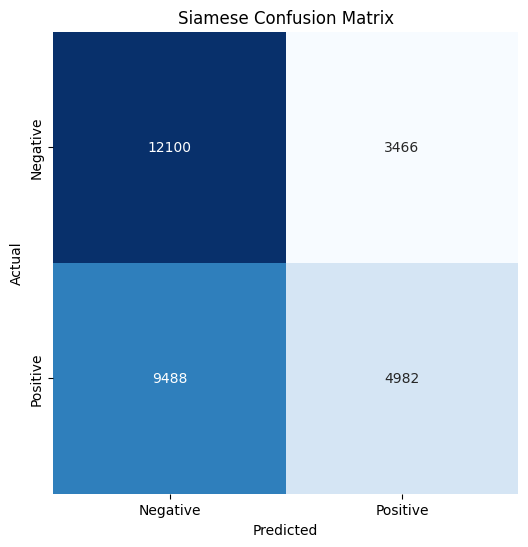

In [ ]:
# Siamese-CNN 모델 예측
y_pred_siamese = (siamese_model.predict([X_test_title, X_test_content]) > 0.5).astype(int)

# Siamese-CNN 평가
accuracy_siamese = accuracy_score(y_test, y_pred_siamese)
precision_siamese = precision_score(y_test, y_pred_siamese)
recall_siamese = recall_score(y_test, y_pred_siamese)
conf_matrix_siamese = confusion_matrix(y_test, y_pred_siamese)

results.append({
                    "Model": "Siamese",
                    "Accuracy": accuracy_siamese,
                    "Precision": precision_siamese,
                    "Recall": recall_siamese,
                    "Confusion Matrix" : conf_matrix_siamese
                })

# Siamese CNN Confusion Matrix 시각화
plot_confusion_matrix(conf_matrix_siamese, "Siamese")

In [ ]:
# Multiplier+Siamese-CNN 모델 학습
siamese_model2 = multi_siamese_cnn(input_dim=150)
siamese_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model2.fit([X_train_title, X_train_content], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/20
1502/1502 [==============================] - 10s 6ms/step - loss: 0.6892 - accuracy: 0.5240 - val_loss: 0.6796 - val_accuracy: 0.5337
Epoch 2/20
1502/1502 [==============================] - 9s 6ms/step - loss: 0.6768 - accuracy: 0.5551 - val_loss: 0.6666 - val_accuracy: 0.5836
Epoch 3/20
1502/1502 [==============================] - 8s 5ms/step - loss: 0.6601 - accuracy: 0.5951 - val_loss: 0.6566 - val_accuracy: 0.6122
Epoch 4/20
1502/1502 [==============================] - 9s 6ms/step - loss: 0.6392 - accuracy: 0.6284 - val_loss: 0.6245 - val_accuracy: 0.6411
Epoch 5/20
1502/1502 [==============================] - 8s 6ms/step - loss: 0.6267 - accuracy: 0.6434 - val_loss: 0.6137 - val_accuracy: 0.6589
Epoch 6/20
1502/1502 [==============================] - 9s 6ms/step - loss: 0.6179 - accuracy: 0.6523 - val_loss: 0.6030 - val_accuracy: 0.6662
Epoch 7/20
1502/1502 [==============================] - 9s 6ms/step - loss: 0.6101 - accuracy: 0.6609 - val_loss: 0.6047 - val_accuracy

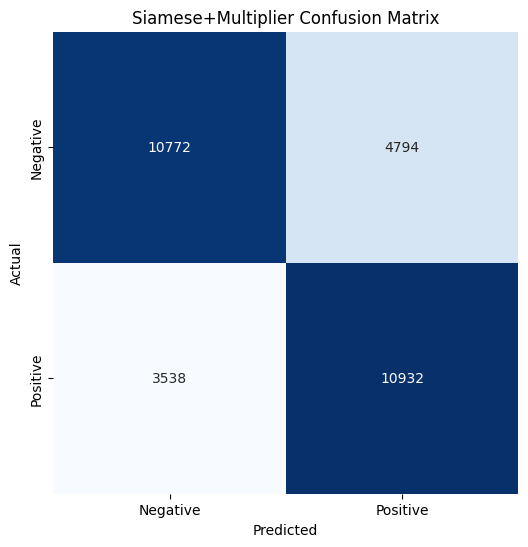

In [ ]:
# Multiplier+Siamese-CNN 모델 예측
y_pred_siamese = (siamese_model2.predict([X_test_title, X_test_content]) > 0.5).astype(int)

# Multiplier+Siamese-CNN 평가
accuracy_siamese = accuracy_score(y_test, y_pred_siamese)
precision_siamese = precision_score(y_test, y_pred_siamese)
recall_siamese = recall_score(y_test, y_pred_siamese)
conf_matrix_siamese = confusion_matrix(y_test, y_pred_siamese)

results.append({
                    "Model": "Siamese+Multiplier",
                    "Accuracy": accuracy_siamese,
                    "Precision": precision_siamese,
                    "Recall": recall_siamese,
                    "Confusion Matrix" : conf_matrix_siamese
                })

# Siamese CNN Confusion Matrix 시각화
plot_confusion_matrix(conf_matrix_siamese, "Siamese+Multiplier")

In [ ]:
# Attention+Siamese-CNN 모델 학습
siamese_model3 = attention_siamese_cnn(input_dim=150)
siamese_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model3.fit([X_train_title, X_train_content], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/20
1502/1502 [==============================] - 10s 6ms/step - loss: 0.6894 - accuracy: 0.5263 - val_loss: 0.6817 - val_accuracy: 0.5428
Epoch 2/20
1502/1502 [==============================] - 8s 5ms/step - loss: 0.6752 - accuracy: 0.5645 - val_loss: 0.6631 - val_accuracy: 0.5944
Epoch 3/20
1502/1502 [==============================] - 8s 6ms/step - loss: 0.6618 - accuracy: 0.5922 - val_loss: 0.6493 - val_accuracy: 0.6158
Epoch 4/20
1502/1502 [==============================] - 8s 5ms/step - loss: 0.6480 - accuracy: 0.6154 - val_loss: 0.6366 - val_accuracy: 0.6308
Epoch 5/20
1502/1502 [==============================] - 8s 5ms/step - loss: 0.6399 - accuracy: 0.6257 - val_loss: 0.6274 - val_accuracy: 0.6393
Epoch 6/20
1502/1502 [==============================] - 8s 6ms/step - loss: 0.6329 - accuracy: 0.6343 - val_loss: 0.6219 - val_accuracy: 0.6457
Epoch 7/20
1502/1502 [==============================] - 7s 5ms/step - loss: 0.6255 - accuracy: 0.6429 - val_loss: 0.6241 - val_accuracy

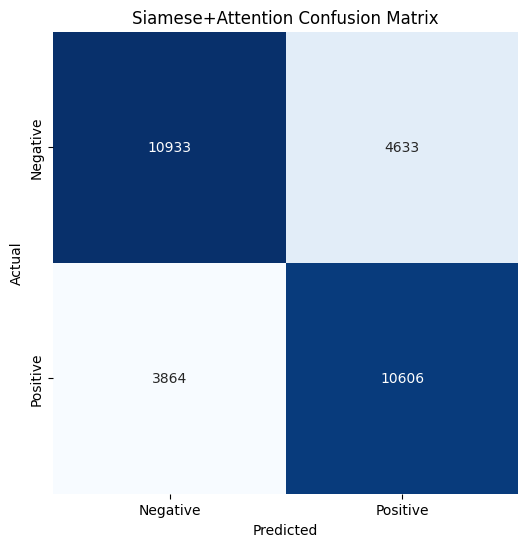

In [ ]:
# Attention+Siamese-CNN 모델 예측
y_pred_siamese = (siamese_model3.predict([X_test_title, X_test_content]) > 0.5).astype(int)

# Attention+Siamese-CNN 평가
accuracy_siamese = accuracy_score(y_test, y_pred_siamese)
precision_siamese = precision_score(y_test, y_pred_siamese)
recall_siamese = recall_score(y_test, y_pred_siamese)
conf_matrix_siamese = confusion_matrix(y_test, y_pred_siamese)

results.append({
                    "Model": "Siamese+Attention",
                    "Accuracy": accuracy_siamese,
                    "Precision": precision_siamese,
                    "Recall": recall_siamese,
                    "Confusion Matrix" : conf_matrix_siamese
                })

# Siamese CNN Confusion Matrix 시각화
plot_confusion_matrix(conf_matrix_siamese, "Siamese+Attention")

In [ ]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,Confusion Matrix
0,Text-CNN,0.563058,0.602748,0.272840,"[[12964, 2602], [10522, 3948]]"
1,Siamese,0.568718,0.589725,0.344299,"[[12100, 3466], [9488, 4982]]"
2,Siamese+Multiplier,0.722600,0.695155,0.755494,"[[10772, 4794], [3538, 10932]]"
3,Siamese+Attention,0.717106,0.695977,0.732965,"[[10933, 4633], [3864, 10606]]"


In [ ]:
results_df.to_csv("/content/drive/MyDrive/기학_팀플젝/박채연/CNN/CNN_models_results_nonPCA.csv")